# Preprocessing Pipeline for Sentinel Data
This notebook covers the full pipeline for preprocessing Sentinel satellite images and masks for segmentation tasks, including downloading, patching, encoding, and TFRecord export.

<a href="https://colab.research.google.com/github/easare377/Prithvi-EO-Segmentation/blob/main/Pre_process_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive and Set Up Paths
Mount Google Drive and define all necessary paths for data storage and access.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from osgeo import gdal, osr
from osgeo import gdal_array
from osgeo import osr
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import re
import uuid
import shutil

In [3]:
data_path = r'/content/drive/MyDrive/SCO_training'
segmentation_path = os.path.join(data_path, 'segmentation')
original_path = os.path.join(segmentation_path, 'original')
real_data_path = os.path.join(original_path, 'real')
# real_data_path = '/Volumes/BOOTCAMP/Users/eopok/Desktop/Sentinel/2022'
mask_data_path = os.path.join(original_path, 'mask')
# divided images
divided_data_path = os.path.join(segmentation_path, 'divided')
real_divided_data_path = os.path.join(divided_data_path, 'real')
mask_divided_data_path = os.path.join(divided_data_path, 'mask')
#
final_data_path = os.path.join(segmentation_path, 'final')
real_final_data_path = os.path.join(final_data_path, 'real')
mask_final_data_path = os.path.join(final_data_path, 'mask')

In [5]:
def create_dir_if_not_exists(path):
    if os.path.exists(path):
        return
    os.makedirs(path)

In [7]:
create_dir_if_not_exists(data_path)
create_dir_if_not_exists(segmentation_path)
create_dir_if_not_exists(original_path)
create_dir_if_not_exists(real_data_path)
create_dir_if_not_exists(mask_data_path)

# Create Directories and Download Data
Create necessary directories and download satellite images and masks from remote sources.

In [8]:

import requests
from tqdm import tqdm
import pathlib


def download_file(url, dest_path, chunk_size=1024*1024):
    """
    Download a large file from a URL with a progress bar.
    Args:
        url (str): File URL.
        dest_path (str): Destination file path.
        chunk_size (int): Download chunk size in bytes.
    """
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as file, tqdm(
        desc=f"Downloading {dest_path}",
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

def get_all_files(path, pattern='*', get_full_path=False):
    files = list(pathlib.Path(path).glob(pattern))
    if get_full_path:
        onlyfiles = [os.path.join(path, f.name) for f in files if f.is_file()]
    else:
        onlyfiles = [f.name for f in files if f.is_file()]
    return onlyfiles

In [16]:
geotiff_image_path = os.path.join(real_data_path, 'sentinel_2024-0000035328-0000023552_harmonized.tif')
download_file('https://sco-training.s3.us-east-2.amazonaws.com/sentinel_2024-0000035328-0000023552_harmonized.tif', geotiff_image_path)

In [17]:
geotiff_mask_path = os.path.join(mask_data_path, 'sentinel_2024-0000035328-0000023552_harmonized.png')
download_file('https://sco-training.s3.us-east-2.amazonaws.com/sentinel_2024-0000035328-0000023552_harmonized.png', geotiff_mask_path)

In [18]:
# stores the path of an image and a mask pair
class DataLabelPair:
    def __init__(self, data_real_path, label_path):
        self.data_real_path = data_real_path
        self.label_path = label_path

In [19]:
#Gets all mask files in the mask folder
original_mask_images_path = get_all_files(real_data_path, '*.tif')
len(original_mask_images_path)

1

In [20]:
images_original = []
for path in original_mask_images_path:
    image = DataLabelPair(os.path.join(real_data_path, path),
                          os.path.join(mask_data_path, path).replace('.tif', '.png'))
    images_original.append(image)

In [14]:
strides = 224, 224
max_grid_size = 224, 224

In [15]:
def get_geoTiff_datatype(geoTiff):
    """
    Get the GDAL data type of a GeoTIFF dataset.

    Parameters:
    - geoTiff (gdal.Dataset): Input GeoTIFF dataset.

    Returns:
    - int: GDAL data type of the GeoTIFF dataset.

    """
    band = geoTiff.GetRasterBand(1)
    return band.DataType


def get_geoTiff_numpy_datatype(geoTiff):
    """
    Get the NumPy data type string of a GeoTIFF dataset.

    Parameters:
    - geoTiff (gdal.Dataset): Input GeoTIFF dataset.

    Returns:
    - str: NumPy data type string of the GeoTIFF dataset.

    """
    gt_dtype = get_geoTiff_datatype(geoTiff)
    gdal_to_numpy_datatype = {
        gdal.GDT_Byte: 'uint8',
        gdal.GDT_UInt16: 'uint16',
        gdal.GDT_Int16: 'int16',
        gdal.GDT_UInt32: 'uint32',
        gdal.GDT_Int32: 'int32',
        gdal.GDT_Float32: 'float32',
        gdal.GDT_Float64: 'float64'
    }
    numpy_datatype = gdal_to_numpy_datatype.get(gt_dtype, None)
    return numpy_datatype


def crop_geoTiff(geoTiff, left, top, right, bottom, dtype=None):
    """
    Crop a GeoTIFF array to the specified region.

    Parameters:
    - geoTiff (gdal.Dataset): Input GeoTIFF dataset.
    - left (int): Left coordinate of the crop region.
    - top (int): Top coordinate of the crop region.
    - right (int): Right coordinate of the crop region.
    - bottom (int): Bottom coordinate of the crop region.
    - dtype (str or None, optional): Desired data type of the output array.
    If set to None, the data type is inferred from the band. Defaults to None.

    Returns:
    - output (numpy.ndarray): Cropped array with dimensions (height, width, bands).

    Raises:
    - ValueError: If the crop dimensions exceed the size of the GeoTIFF.
    """
    if (int(right) > geoTiff.RasterXSize) or (int(bottom) > geoTiff.RasterYSize):
        # print(right, bottom)
        # print(geoTiff.RasterXSize, geoTiff.RasterYSize)
        raise ValueError('Crop dimensions exceed the size of the GeoTIFF.')
    if dtype is None:
        dtype = get_geoTiff_numpy_datatype(geoTiff)
    width = abs(right - left)
    height = abs(top - bottom)
    output = np.zeros(
        (int(height), int(width), geoTiff.RasterCount), dtype)
    # bands = [None] * geoTiff.RasterCount
    for x in range(geoTiff.RasterCount):
        band = geoTiff.GetRasterBand(x + 1).ReadAsArray(left, top,
                                                        int(width), int(height))
        output[..., x] = band
    return output


def read_geoTiff_bands(geoTiff, bands=None, bbox=None, dtype='uint16'):
    width = geoTiff.RasterXSize
    height = geoTiff.RasterYSize
    if bbox == None:
       bbox = (0, width, 0, height)
    left, right, top, bottom = bbox
    bb_width = right - left
    bb_height = bottom - top
    band_list = []
    if bands != None:
        for val in bands:
            band = geoTiff.GetRasterBand(val).ReadAsArray(left, top,
                                                          int(bb_width), int(bb_height))
            band_list.append(band)
    else:
        for x in range(geoTiff.RasterCount):
            band = geoTiff.GetRasterBand(x + 1).ReadAsArray(left, top,
                                                            int(bb_width), int(bb_height))
            band_list.append(band)
    output = np.zeros(
        (int(bb_height), int(bb_width), len(band_list)), dtype)
    for x in range(len(band_list)):
        output[..., x] = band_list[x]
    return output


def read_image(path, color_space=None):
    if color_space is None:
        img = Image.open(path)
    else:
        img = Image.open(path).convert(color_space)
    return img


def split_geoTiff_image(geoTiff, max_grid_size, strides, dtype = 'uint16'):
    parts = []
    width, height = geoTiff.RasterXSize, geoTiff.RasterYSize
    left = 0
    top = 0
    stride_width, stride_height = strides
    max_grid_width, max_grid_height = max_grid_size
    total_grids = np.ceil(height / stride_width) * np.ceil(width / stride_height)
    for r in range(0, height, stride_height):
        for c in range(0, width, stride_width):
            left, top = c, r
            right, bottom = min(
                    c + max_grid_width, width), min(r + max_grid_height,height)
            grid = crop_geoTiff(
                    geoTiff, left, top, right, bottom, dtype)
            # part = gu.crop_geoTiff(geoTiff, left, top, right, bottom)
            parts.append(grid)
    return parts


def split_image(image, max_grid_size, strides):
    width, height = image.size
    left = 0
    top = 0
    stride_width, stride_height = strides
    max_grid_width, max_grid_height = max_grid_size

    for r in range(0, height, stride_height):
        for c in range(0, width, stride_width):
            left, top = c, r
            right, bottom = min(c + max_grid_width, width), min(r + max_grid_height, height)
            grid = image.crop((left, top, right, bottom))
            yield grid  # Yield the grid as a generator


def print_progress(current, total):
    # Calculate the percentage of progress
    progress = (current / total) * 100
    # Print the progress bar
    print("\rProgress: [{0:50s}] {1:.1f}%".format(
        '#' * int(progress/2), progress), end="")

In [21]:
create_dir_if_not_exists(mask_divided_data_path)
create_dir_if_not_exists(real_divided_data_path)

for i, image_original in enumerate(images_original, 1):
    real_image = gdal.Open(image_original.data_real_path)
    np_real_image = read_geoTiff_bands(real_image, dtype='float32')
    mask_image = read_image(image_original.label_path, 'L')
    mask_image = mask_image.resize((real_image.RasterXSize, real_image.RasterYSize), Image.NEAREST)

    gt = real_image.GetGeoTransform()

    filename = os.path.basename(image_original.data_real_path)
    match = re.search(r'(\d{4})', filename)
    if match:
        year = int(match.group(1))
    else:
        year = 2023

    # Generate patches first to know their total number
    real_patches = list(split_geoTiff_image(real_image, max_grid_size, strides, 'float32'))
    mask_patches = list(split_image(mask_image, max_grid_size, strides))

    grid_h = max((np_real_image.shape[1] - max_grid_size[0]) // strides[0] + 1, 1)
    grid_w = max((np_real_image.shape[2] - max_grid_size[1]) // strides[1] + 1, 1)

    for idx, (gt_image_part, mask_image_part) in enumerate(zip(real_patches, mask_patches)):
        part_filename = str(uuid.uuid4())

        h, w = gt_image_part.shape[1], gt_image_part.shape[2]

        patch_row = idx // grid_w
        patch_col = idx % grid_w
        x_offset = patch_col * strides[1]
        y_offset = patch_row * strides[0]

        x_center = x_offset + w // 2
        y_center = y_offset + h // 2

        lon = gt[0] + x_center * gt[1] + y_center * gt[2]
        lat = gt[3] + x_center * gt[4] + y_center * gt[5]

        temporal_coords = np.array([[year, 1]], dtype=np.float32)
        location_coords = np.array([lat, lon], dtype=np.float32)

        # ---- CLASS REMAPPING ----
        mask_image_part = np.array(mask_image_part)
        mask_image_part = mask_image_part.copy()
        mask_image_part[np.isin(mask_image_part, [1, 2])] = 1
        mask_image_part[mask_image_part == 3] = 2

        np.savez(
            os.path.join(real_divided_data_path, part_filename + '.npz'),
            array1=gt_image_part,
            temporal_coords=temporal_coords,
            location_coords=location_coords
        )
        # Save the mask as npz
        np.savez(
            os.path.join(mask_divided_data_path, part_filename + '.npz'),
            mask=mask_image_part
        )
        #mask_image_part.save(os.path.join(mask_divided_data_path, part_filename + '.png'))

    print_progress(i, len(images_original))


/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Progress: [##################################################] 100.0%

# Patch and Encode Images and Masks
Split large images and masks into smaller patches, encode them, and save as NPZ files for further processing.

In [22]:
#Images that do not contain any information is deleted from storage.
divided_images_path = get_all_files(mask_divided_data_path)
len(divided_images_path)

532

In [23]:
images_divided = []
for path in divided_images_path:
    image = DataLabelPair(os.path.join(real_divided_data_path, path),
                          os.path.join(mask_divided_data_path, path))
    images_divided.append(image)

In [24]:
def load_numpy_file(path):
    loaded = np.load(path, allow_pickle=True)
    return loaded['array1']


def display_np_geoTiff(np_geoTiff, rgb_bands, max = None):
    r, g, b = rgb_bands
    red_band = np_geoTiff[:, :, r]
    green_band = np_geoTiff[:, :, g]
    blue_band = np_geoTiff[:, :, b]
    shape = np_geoTiff.shape
    # max = np_geoTiff.max()
    # np_rgb_image = np_geoTiff[:, :, 0:3][:, :, ::-1]
    rgbOutput = np.zeros((shape[0], shape[1], 3), dtype=np_geoTiff.dtype)
    rgbOutput[..., 0] = red_band
    rgbOutput[..., 1] = green_band
    rgbOutput[..., 2] = blue_band
    if max is None:
       max = rgbOutput.max()
    if max == 0:
       max = 1
    rgbOutput = (rgbOutput / max) * 255
    im = Image.fromarray(np.array(rgbOutput, dtype=np.uint8))
    return im

def display_legend(np_image, color_encoding):
    flat_gh_im = np_image.reshape(-1, 1)
    #
    new_gh_im = [None] * flat_gh_im.shape[0]
    for x in range(flat_gh_im.shape[0]):
        new_gh_im[x] = color_encoding.get(flat_gh_im[x][0], [0, 0, 0])
    #
    new_gh_im = np.array(new_gh_im).reshape(
        np_image.shape[0], np_image.shape[1], 3)
    enc_im = Image.fromarray(np.array(new_gh_im, dtype=np.uint8))
    return enc_im

def overlay_mask(original_image, mask_image):
    # Open the image and mask
    image = original_image.convert('RGBA')
    mask = mask_image.convert('RGBA')

    # Make pixel value [0, 0, 0] transparent in the mask
    mask_data = mask.getdata()
    new_mask_data = []
    for item in mask_data:
        if item[:3] == (0, 0, 0):
            # Set transparency for [0, 0, 0]
            new_mask_data.append((0, 0, 0, 0))
        else:
            new_mask_data.append(item)
    mask.putdata(new_mask_data)

    # Overlay the mask on the image
    overlaid = Image.alpha_composite(image, mask)

    # Save the overlaid image
    return overlaid

def display_images(image_dict, grid):
    if not isinstance(image_dict, dict):
        raise ValueError("The 'image_dict' parameter must be a dictionary.")
    rows, cols = grid
    num_images = len(image_dict)

    if rows is None and cols is None:
        rows = int(num_images ** 0.5)
        cols = int(num_images ** 0.5)
    elif rows is None:
        rows = (num_images + cols - 1) // cols
    elif cols is None:
        cols = (num_images + rows - 1) // rows

    fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

    labels = list(image_dict.keys())
    images = list(image_dict.values())

    for i, ax in enumerate(axs.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
            ax.set_title(labels[i])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
new_color_encoding = {2: [180, 96, 0],  # Stream
                      1: [251, 72, 196],  # Open Mine
                      0: [0, 0, 0]}  # No data

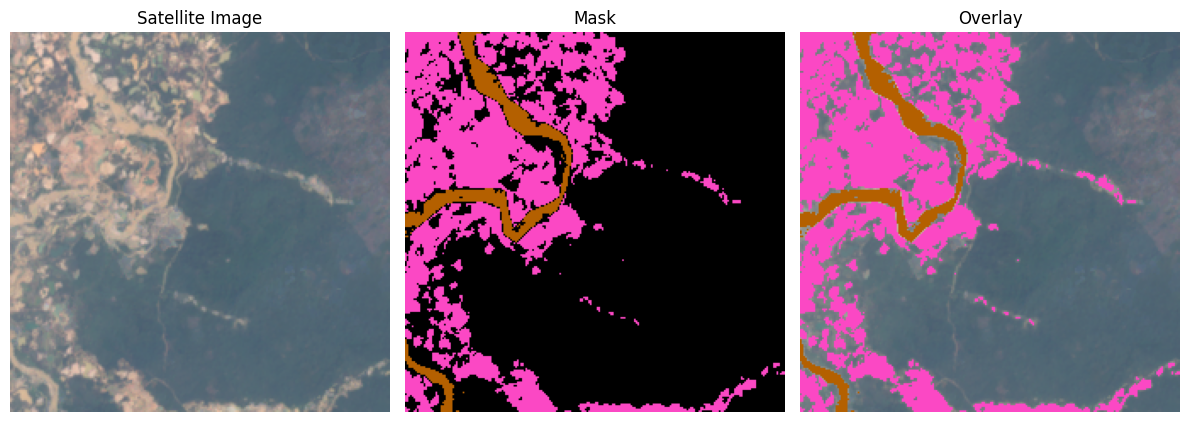

In [38]:
#20  12
import random
indx = random.randint(0, len(divided_images_path))
np_gt = load_numpy_file(images_divided[indx].data_real_path)
real_im = display_np_geoTiff(np_gt, (2, 1, 0))
with np.load(images_divided[indx].label_path) as np_mask:
                mask_array = np_mask[np_mask.files[0]].astype(np.uint8)
mask = display_legend(mask_array, new_color_encoding)
display_images({'Satellite Image': real_im, 'Mask': mask,
                'Overlay': overlay_mask(real_im, mask)}, (1, 3))

In [39]:
# Splits dataset into training, validation and test sets.
def train_val_test_split(val_per, test_per, input_data, labels=None):
    if labels is not None and len(input_data) != len(labels):
        raise Exception("input data and label length mismatch")
    data_len = len(input_data)
    val_len = int(data_len * (val_per / 100))
    test_len = int(data_len * (test_per / 100))
    x_val = input_data[0: val_len]
    x_test = input_data[val_len: val_len + test_len]
    x_train = input_data[val_len + test_len: data_len]
    if labels is not None:
        y_val = labels[0: val_len]
        y_test = labels[val_len: val_len + test_len]
        y_train = labels[val_len + test_len: data_len]
        return (x_train, y_train), (x_val, y_val), (x_test, y_test)
    else:
        return x_train, x_val, x_test

# Split Dataset into Train, Validation, and Test Sets
Divide the processed image and mask pairs into training, validation, and test sets for model development.

In [40]:
train_images, val_images, test_images = train_val_test_split(
    15, 0, images_divided)
print('Train length:', len(train_images))
print('Val length:', len(val_images))
print('Test length', len(test_images))

Train length: 453
Val length: 79
Test length 0


In [41]:
#create directories for all training data.
training_path = os.path.join(segmentation_path, 'training')
create_dir_if_not_exists(training_path)
#train
train_path = os.path.join(training_path, 'train')
create_dir_if_not_exists(train_path)
train_real_path = os.path.join(train_path, 'real')
create_dir_if_not_exists(train_real_path)
train_mask_path = os.path.join(train_path, 'mask')
create_dir_if_not_exists(train_mask_path)
#val
val_path = os.path.join(training_path, 'val')
create_dir_if_not_exists(val_path)
val_real_path = os.path.join(val_path, 'real')
create_dir_if_not_exists(val_real_path)
val_mask_path = os.path.join(val_path, 'mask')
create_dir_if_not_exists(val_mask_path)
#test
test_path = os.path.join(training_path, 'test')
create_dir_if_not_exists(test_path)
test_real_path = os.path.join(test_path, 'real')
create_dir_if_not_exists(test_real_path)
test_mask_path = os.path.join(test_path, 'mask')
create_dir_if_not_exists(test_mask_path)


# Organize Data into Train, Validation, and Test Folders
Move the split data into dedicated directories for training, validation, and testing.

In [42]:
# copy training images to training folder
i = 0
for image in train_images:
    shutil.move(image.data_real_path, os.path.join(
        train_real_path, os.path.basename(image.data_real_path)))
    shutil.move(image.label_path, os.path.join(
        train_mask_path, os.path.basename(image.label_path)))
    i += 1
    print_progress(i, len(train_images))

Progress: [##################################################] 100.0%

In [43]:
# copy training images to training folder
i = 0
for image in val_images:
    shutil.move(image.data_real_path, os.path.join(
        val_real_path, os.path.basename(image.data_real_path)))
    shutil.move(image.label_path, os.path.join(
        val_mask_path, os.path.basename(image.label_path)))
    i += 1
    print_progress(i, len(val_images))

Progress: [##################################################] 100.0%

In [44]:
def delete_file(file_path):
    """
    Deletes the specified file if it exists.

    Parameters:
    - file_path (str): Path to the file to delete.

    Returns:
    - None

    Raises:
    - FileNotFoundError: If the file does not exist.
    - OSError: If there is an error during deletion.
    """
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"Deleted file: {file_path}")
    else:
        raise FileNotFoundError(f"File not found: {file_path}")

In [45]:
import tensorflow as tf
import numpy as np
import os, sys

# --- helpers -----------------------------------------------------------------
def _bytes_feature(value):
    if isinstance(value, np.ndarray):
        value = value.tobytes()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    if not isinstance(value, (list, tuple)):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    if isinstance(value, np.ndarray):
        value = value.flatten().tolist()
    elif isinstance(value, (list, tuple)):
        value = list(value)
    else:
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def write_tfrecords(image_paths, mask_paths, tfrecord_filename):
    """
    Serialise paired .npz images & masks into a TFRecord, including temporal and location coords.
    """
    assert len(image_paths) == len(mask_paths), "image_paths and mask_paths length mismatch"
    total = len(image_paths)
    #options = tf.io.TFRecordOptions(compression_type="GZIP")   # or "ZLIB"
    with tf.io.TFRecordWriter(tfrecord_filename) as writer:
        for i, (img_p, msk_p) in enumerate(zip(image_paths, mask_paths), 1):
            # load image .npz (expects keys: array1, temporal_coords, location_coords)
            with np.load(img_p) as img_npz:
                img_array = img_npz['array1'].astype(np.float32)
                temporal_coords = img_npz['temporal_coords'].astype(np.float32).flatten()   # shape (2,)
                location_coords = img_npz['location_coords'].astype(np.float32).flatten()   # shape (2,)

            with np.load(msk_p) as msk_npz:
                mask_array = msk_npz[msk_npz.files[0]].astype(np.uint8)

            # (h, w, c) or (c, h, w)?
            if img_array.shape[0] <= 10:  # (bands, H, W)
                c, h, w = img_array.shape
                img_array = np.transpose(img_array, (1, 2, 0))  # (H, W, C) for TF
            else:
                h, w, c = img_array.shape

            # build Example
            example = tf.train.Example(features=tf.train.Features(feature={
                "image_raw": _bytes_feature(img_array),
                "mask_raw":  _bytes_feature(mask_array),
                "height":    _int64_feature(h),
                "width":     _int64_feature(w),
                "channels":  _int64_feature(c),
                "image_name": _bytes_feature(os.path.basename(img_p).encode()),
                "mask_name":  _bytes_feature(os.path.basename(msk_p).encode()),
                "temporal_coords": _float_feature(temporal_coords),    # [year, doy]
                "location_coords": _float_feature(location_coords),    # [lat, lon]
            }))
            writer.write(example.SerializeToString())

            if i % 500 == 0:
               writer.flush()
            # progress bar
            pct = int(i * 100 / total)
            sys.stdout.write(f"\r▶  {pct:3d}%")
            sys.stdout.flush()
            delete_file(img_p)
            delete_file(msk_p)

    sys.stdout.write("\r✔  100%  TFRecord written → {}\n".format(tfrecord_filename))
    sys.stdout.flush()


# Export Data to TFRecord Format
Convert the processed image and mask pairs into TFRecord files for efficient training in TensorFlow.

In [46]:
train_img_paths = sorted(get_all_files(train_real_path, '*.npz', True))
train_mask_paths = sorted(get_all_files(train_mask_path, '*.npz', True))
print('real:',len(train_img_paths), 'mask:', len(train_mask_paths))

real: 453 mask: 453


In [47]:
write_tfrecords(train_img_paths, train_mask_paths, "/content/drive/MyDrive/SCO_training/ssm_footprint_train.tfrecord")

✔  100%  TFRecord written → /content/drive/MyDrive/SCO_training/ssm_footprint_train.tfrecord


In [48]:
val_img_paths = sorted(get_all_files(val_real_path, '*.npz', True))
val_mask_paths = sorted(get_all_files(val_mask_path, '*.npz', True))
print('real:',len(val_img_paths), 'mask:', len(val_mask_paths))

real: 79 mask: 79


In [49]:
write_tfrecords(val_img_paths, val_mask_paths, "/content/drive/MyDrive/SCO_training/ssm_footprint_val.tfrecord")

✔  100%  TFRecord written → /content/drive/MyDrive/SCO_training/ssm_footprint_val.tfrecord
